# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib
import scipy.stats as stats

# Max Funktionen

In [2]:
######## Forces
def Ball_F_nucleus_in_bridge(bwidth, E1, D=10e-6, nu=0.5): #checked
    alpha = (D - bwidth) / 2
    V1 = (1-nu**2) / (np.pi * E1) 
    forefactor = 0.5* (3*np.pi)**(2/3) 
    F = forefactor**(-3/2) * alpha**(3/2) * V1**-1 * D**(1/2) 
    return F 

def Ball_F_nucleus_in_soft_bridge(bridgewidth_initial=7e-6, E_gel=2.7e3, D_initial=14e-6, E_ball=13e-6, nu_gel=0.5, nu_ball=0.5):
    alpha = (D_initial - bridgewidth_initial) / 2 
    V1 = (1-nu_gel**2) / (np.pi * E_gel)
    V2 = (1-nu_ball**2) / (np.pi * E_ball)
    forefactor = 0.5* (3*np.pi)**(2/3) 
    F = forefactor**(-3/2) * alpha**(3/2) * (V1+V2)**-1 * D_initial**(1/2) 
    return F

def hertz_force(disp = 0.4e-6, bridgewidth_initial=7e-6, E_gel=2.7e3, D_initial=14e-6, nu_gel=0.5, nu_ball=0.5):
    #actually bridgewidth cancels out in this
    h = np.abs(disp)*2 + bridgewidth_initial
    f = 4/3 * (E_gel/1-nu_gel**2) * D_initial**0.5 * (h/2 - bridgewidth_initial/2)**(3/2)
    return f

def hertz_force_soft_ball(disp = 0.4e-6, bridgewidth_initial=7e-6, E_gel=2.7e3, D_initial=14e-6, E_ball=420, nu_gel=0.5, nu_ball=0.5):
    h = np.abs(disp)*2 + bridgewidth_initial
    E_star_inverse =  (1 - nu_ball**2) / E_ball + (1 - nu_gel**2) / E_gel  # prefactors

    f = 4/3 * E_star_inverse**-1 * D_initial**0.5 * (h/2 - bridgewidth_initial/2)**(3/2)
    return f

###########Indents
def hertz_indent(f, E_tip, E_gel, R=5e-6, nu_tip=0.5, nu_gel=0.5):
    Eprime = 1/( (1-nu_tip**2)/(E_tip) + (1-nu_gel**2)/(E_gel))
    indent = ( f / (4/3 * Eprime * R**0.5) )**(2/3)
    return indent

def hertz_indent_hard_ball(f, E_gel, R=7e-6, nu_gel=0.5):
    Eprime = E_gel / (1 - nu_gel**2)
    indent = ( f / (4/3 * Eprime * R**0.5) )**(2/3)
    return indent

def gel_displacement(E_gel=3e3, bridgewidth_initial=7e-6, E_ball=400, D_initial=14e-6, nu_gel=0.5, nu_ball=0.5): # function made with Johannes
    Eb = E_ball / (1 - nu_ball**2) # prefactors
    Eg = E_gel / (1 - nu_gel**2)
    a = Eb / (Eb + Eg)
    disp = a * (D_initial / 2 - bridgewidth_initial / 2)
    #print(a/2)
    return disp

######### E's from disp
def with_disp_E_gel(disp = 1e-6, bridgewidth_initial=7e-6, E_ball=1.1e3, D_initial=14e-6, nu_gel=0.5, nu_ball=0.5):
    Eb = E_ball / (1 - nu_ball**2)
    Eg = Eb * (( D_initial - bridgewidth_initial) / 2) / disp - Eb
    return (1 - nu_gel**2) * Eg

def with_disp_E_Ball(disp = 0.4e-6, bridgewidth_initial=7e-6, E_gel=3.1e3, D_initial=14e-6, nu_gel=0.5, nu_ball=0.5):
    Eg = E_gel / (1 - nu_gel**2)
    Delta = (( D_initial - bridgewidth_initial) / 2)
    Eb = Eg * (disp/Delta) / (1 - disp / Delta)
    E_ball = Eb * (1 - nu_ball**2)
    return E_ball

def with_disp_E_Ball_Thesis(disp = 0.4e-6, bridgewidth_initial=7e-6, E_gel=3.1e3, D_initial=14e-6, nu_gel=0.5, nu_ball=0.5):
    Eg = E_gel / (1 - nu_gel**2)
    Delta = (( D_initial - bridgewidth_initial) / 2)
    Eb = Eg * (disp/(Delta - disp))**3/2
    E_ball = Eb * (1 - nu_ball**2)
    return E_ball

# HeLa Fit

In [3]:
HeLa_data = np.asarray([[5, 100], [6, 70], [7, 40], [8, 20], [9, 8], [10, 0]]).T
initial_radius_HeLa = 5

6167.8601234231155


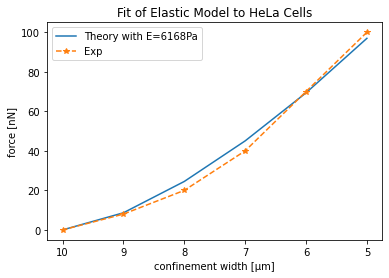

In [4]:
parameters, covariance = curve_fit(Ball_F_nucleus_in_bridge, HeLa_data[0]*1e-6, HeLa_data[1]*1e-9, p0=5e2)

fit = parameters[0]
print(fit)



forces = []
confh = []
for conf in range(5, 11):#400nN
    forces.append(Ball_F_nucleus_in_bridge(conf*1e-6, fit, initial_radius_HeLa*2e-6, 0.5)*1e9) 
    confh.append(conf)
    
plt.plot(confh, forces, label=str("Theory with E="+str(int(np.round(parameters[0])))+"Pa"))
plt.plot(HeLa_data[0], HeLa_data[1], "--*", label="Exp")
plt.xlabel("confinement width [µm]")
plt.ylabel("force [nN]")
ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])
plt.draw()
plt.legend()
plt.title("Fit of Elastic Model to HeLa Cells")
plt.savefig("HeLa_fit.png", dpi=300)

# Range finding where visible disp

In [5]:
confh

[5, 6, 7, 8, 9, 10]

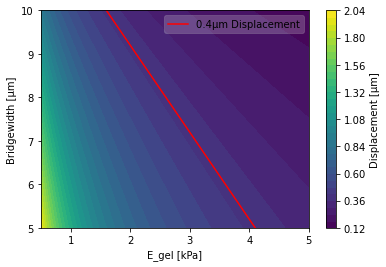

In [6]:
E_gel = np.linspace(0.5e3, 5e3)
d = 14e-6
confhSI = np.array(confh)*1e-6
[X, Y] = np.meshgrid(E_gel, confhSI)
#Z = hertz_indent(Ball_F(Y, X, d), 2e200,  E_gel = X, R=d/2)
#Z = Ball_F(Y, X, d)
Z = gel_displacement(X, Y, 400, d)
plt.contourf(X*1e-3,Y*1e6, Z*1e6, 30)
plt.colorbar(label="Displacement [µm]")
plt.plot(with_disp_E_gel(0.4e-6, confhSI, 400, d)*1e-3, confhSI*1e6, color="red", label="0.4µm Displacement")
plt.xlim([E_gel.min()*1e-3, E_gel.max()*1e-3])
plt.xlabel("E_gel [kPa]")
plt.ylabel("Bridgewidth [µm]")
plt.legend(framealpha=0.2)
plt.title("")
plt.savefig("E_vs_Bw_vs_disps.png", dpi=300)
plt.savefig("E_vs_Bw_vs_disps.pdf", dpi=300)
plt.show()

array([-0.55999999, -0.46666666, -0.4       , -0.35      , -0.31111111,
       -0.28      ])

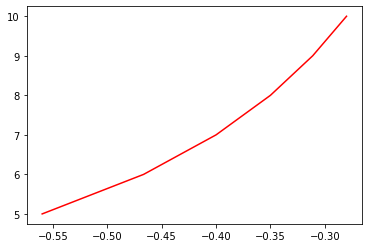

In [7]:
plt.plot(with_disp_E_gel(confhSI, 400, d)*1e-3, confhSI*1e6, color="red", label="1µm Displacement")
with_disp_E_gel(confhSI, 400, d)*1e-3

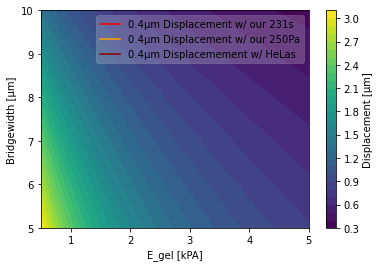

In [8]:
E_gel = np.linspace(0.5e3, 5e3)
confhSI = np.array(confh)*1e-6
[X, Y] = np.meshgrid(E_gel, confhSI)
#Z = hertz_indent(Ball_F(Y, X, d), 2e200,  E_gel = X, R=d/2)
#Z = Ball_F(Y, X, d)
Z = gel_displacement(X, Y, 1100, d)
plt.contourf(X*1e-3,Y*1e6, Z*1e6, 30)
plt.colorbar(label="Displacement [µm]")
plt.plot(with_disp_E_gel(confhSI, 1100, d)*1e-3, confhSI*1e6, color="red", label="0.4µm Displacement w/ our 231s")
plt.plot(with_disp_E_gel(confhSI, 250, d)*1e-3, confhSI*1e6, color="orange", label="0.4µm Displacement w/ our 250Pa")
plt.plot(with_disp_E_gel(confhSI, 6200, d)*1e-3, confhSI*1e6, color="darkred", label="0.4µm Displacemement w/ HeLas")

plt.xlim([E_gel.min()*1e-3, E_gel.max()*1e-3])
plt.xlabel("E_gel [kPA]")
plt.ylabel("Bridgewidth [µm]")
plt.legend(framealpha=0.2)
plt.title("")
plt.savefig("E_vs_Bw_vs_disps_HeLa_and250Pa_incl.png")
plt.show()

In [9]:
#XY 21 D=13µm and Bridgewith 8µm

#gel_displacement(1600, 8*1e-6, x, 13e-6, 0.5, 0.5)*1e6

# Theory Pred vs Measurend indentation

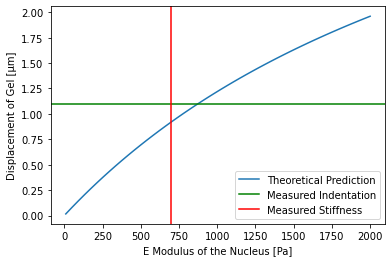

In [10]:
#parameters, covariance = curve_fit(gel_displacement,1600, 8e-6, HeLa_data[1]*1e-9, p0=5e2)

#fit = parameters[0]
#print(fit)



x=np.linspace(10,2000)
    
plt.plot(x, gel_displacement(3100, 5.0*1e-6, x, 15e-6, 0.5, 0.5)*1e6, label="Theoretical Prediction")
plt.axhline(1.1, color="g", label="Measured Indentation")
plt.axvline(700, color="r", label="Measured Stiffness")
plt.xlabel("E Modulus of the Nucleus [Pa]")
plt.ylabel("Displacement of Gel [µm]")
#ax = plt.gca()
#ax.set_xlim(ax.get_xlim()[::-1])
plt.legend()
plt.savefig("E_Nucleus_Fit_0307.png", dpi=300)

In [11]:
gel_displacement(3100, 5.2*1e-6, 700, 13e-6, 0.5, 0.5)*1e6

0.718421052631579

# Focal Plane Problem

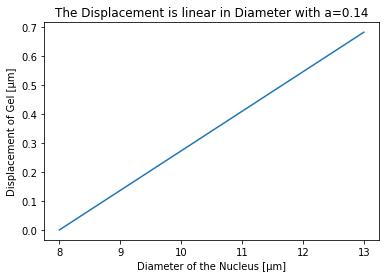

In [12]:
bridge_width = 8
nucleus_diameter = 13
ds=np.linspace(bridge_width, nucleus_diameter)
    
plt.plot(ds, gel_displacement(1600, 8*1e-6, 600, ds*1e-6, 0.5, 0.5)*1e6, label="Theoretical Prediction")

plt.title(f"The Displacement is linear in Diameter with a={np.round(0.1363,2)}")
plt.xlabel("Diameter of the Nucleus [µm]")
plt.ylabel("Displacement of Gel [µm]")
#plt.legend()
plt.savefig("Gel_Disp_of_z_1.png", dpi=300)

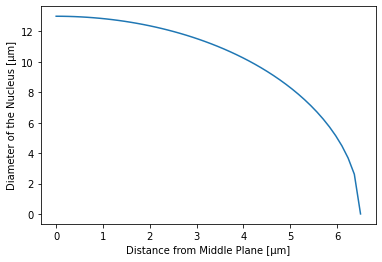

In [13]:
z_dist_from_middle = np.linspace(0, nucleus_diameter/2)
diamater_of_z = nucleus_diameter * np.cos( np.arcsin(z_dist_from_middle/(nucleus_diameter/2)) )
plt.plot(z_dist_from_middle, diamater_of_z)
plt.ylabel("Diameter of the Nucleus [µm]")
plt.xlabel("Distance from Middle Plane [µm]")
plt.savefig("Gel_Disp_of_z_2.png", dpi=300)

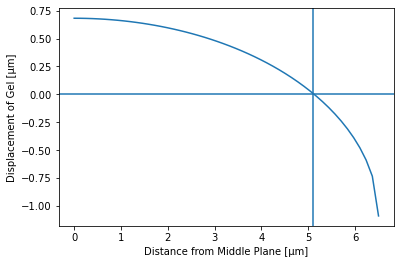

In [14]:
plt.plot(z_dist_from_middle, gel_displacement(1600, 8*1e-6, 600, diamater_of_z*1e-6, 0.5, 0.5)*1e6, label="Theoretical Prediction")


plt.xlabel("Distance from Middle Plane [µm]")
plt.ylabel("Displacement of Gel [µm]")
plt.axhline(0)
plt.axvline(5.1)
#plt.legend()
plt.savefig("Gel_Disp_of_z_3.png", dpi=300)

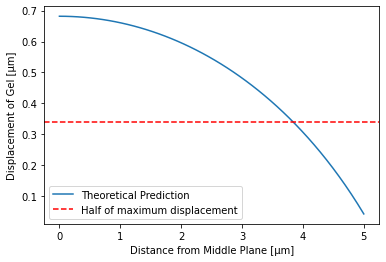

In [15]:
z_dist_from_middle = np.linspace(0, 5)
diamater_of_z = nucleus_diameter * np.cos( np.arcsin(z_dist_from_middle/(nucleus_diameter/2)) )
plt.plot(z_dist_from_middle, gel_displacement(1600, 8*1e-6, 600, diamater_of_z*1e-6, 0.5, 0.5)*1e6, label="Theoretical Prediction")


plt.xlabel("Distance from Middle Plane [µm]")
plt.ylabel("Displacement of Gel [µm]")
plt.axhline((gel_displacement(1600, 8*1e-6, 600, diamater_of_z*1e-6, 0.5, 0.5)*1e6)[0]/2, c="r", ls="--", label="Half of maximum displacement")
#plt.axvline(5.1)
plt.legend()
plt.savefig("Gel_Disp_of_z_4.png", dpi=300)

# Data from E(t)

In [17]:
# I define these global lists and save the effective stiffnesses of every video in them
# running through the data adds up the global results lists.
big_res = []
big_res_fn = []
big_res_fn_soft = []
initial_widths = []
big_res_E_hydrogel =[]
data_path = "Data/disps/"

In [18]:
def effective_E(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5): #all in SIunits
    res = with_disp_E_Ball(displacements, bridgewidth_initial, E_gel, Diameter_nucleus, nu_gel, nu_ball)
    big_res.append(res.tolist())
    res_h = with_disp_E_gel(displacements, bridgewidth_initial, 730, Diameter_nucleus, nu_gel=0.5, nu_ball=0.5)
    big_res_E_hydrogel.append(res_h.tolist())
    
    fig, ax = plt.subplots()
    ax.boxplot([res])
    ax.set_ylabel("Stiffness [Pa]")
    #ax.set_xlabel("All together, 1st, 2nd, & 3rd Transition [Pa]")
    #ax.set_title(f'Stiffness of the Nucleus: left: all together, right: 1st, 2nd, & 3rd Transition')
    ax.set_xticklabels([f"{int(np.round(np.mean(res),-1))} $\pm$ {int(np.round(res.std(),-1))} [Pa]"])
    ax.set_title(name)
    fig.savefig(str(name+"_EffectiveE.png"), dpi=300)
    plt.show()
    
def measured_Fn_plots(name, displacements, bridgewidth_initial, Diameter_nucleus, E_ball=420, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5): #all in SIunits
    res_soft = hertz_force_soft_ball(displacements, bridgewidth_initial, E_gel, Diameter_nucleus, E_ball, nu_gel, nu_ball)# result seems too low
    res = hertz_force(displacements, bridgewidth_initial, E_gel, Diameter_nucleus, nu_gel, nu_ball)
    
    big_res_fn.append(res.tolist())
    big_res_fn_soft.append(res_soft.tolist())
    initial_widths.append(bridgewidth_initial)
    
    fig, ax = plt.subplots()
    ax.violinplot([res])
    ax.set_ylabel("Force [N]")
    #ax.set_xlabel("All together, 1st, 2nd, & 3rd Transition [Pa]")
    #ax.set_title(f'Stiffness of the Nucleus: left: all together, right: 1st, 2nd, & 3rd Transition')
    ax.set_xticks([1])
    ax.set_xticklabels([f"{np.round(np.mean(res*1e9))} $\pm$ {np.round((res*1e9).std())} [nN]"])
    ax.set_title(name)
    fig.savefig(str(name+"_Measured_Fn.png"), dpi=300)
    plt.show()

## 20220307

### XY30

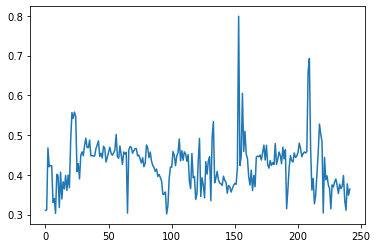

In [19]:
name = "20220307_XY30"
disps = np.load(data_path + name + ".npy")
Diameter_nucleus = 15e-6
displacements= disps*1e-6
bridgewidth_initial = 5.0e-6

gel_displacement(1600, 8*1e-6, 600, 13*1e-6, 0.5, 0.5)*1e6
plt.plot(disps)

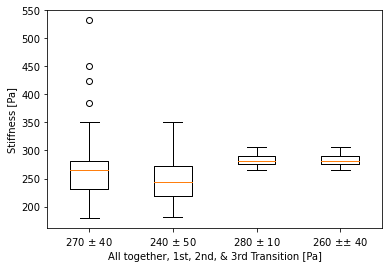

In [20]:
res = with_disp_E_Ball(disp = disps*1e-6, bridgewidth_initial=5.0e-6, E_gel=2.8e3, D_initial=15e-6, nu_gel=0.5, nu_ball=0.5)
res1, res2, res3 = res[:30], res[30:55], res[55:]
fig, ax = plt.subplots()

ax.boxplot([res, res1, res2, res2])
ax.set_ylabel("Stiffness [Pa]")
ax.set_xlabel("All together, 1st, 2nd, & 3rd Transition [Pa]")
#ax.set_title(f'Stiffness of the Nucleus: left: all together, right: 1st, 2nd, & 3rd Transition')
ax.set_xticklabels([f"{int(np.round(np.median(res),-1))} $\pm$ {int(np.round(res.std(),-1))}", f"{int(np.round(np.median(res1),-1))} $\pm$ {int(np.round(res1.std(),-1))}", f"{int(np.round(np.median(res2),-1))} $\pm$ {int(np.round(res2.std(),-1))}", f"{int(np.round(np.median(res3),-1))} $\pm$$\pm$ {int(np.round(res3.std(),-1))}"])
fig.savefig("20220307_XY30_EBall.png", dpi=300)
plt.show()

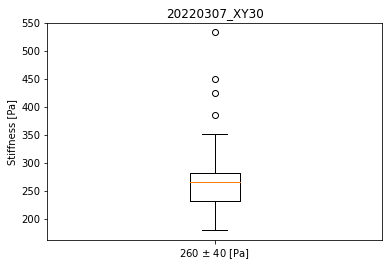

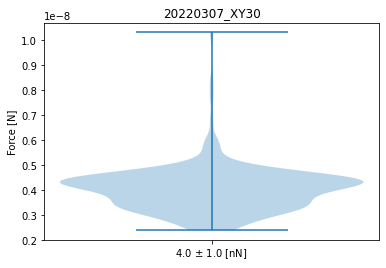

In [21]:
effective_E(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)
measured_Fn_plots(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)

### XY22

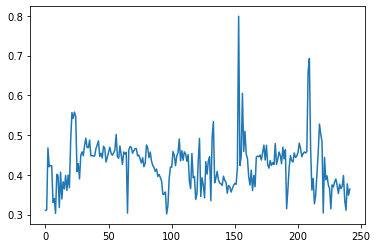

In [22]:
name = "20220307_XY22"
disps = np.load(data_path + name + ".npy")
Diameter_nucleus = 13e-6
displacements= disps[disps>0.45]*1e-6
bridgewidth_initial = np.mean([6.192, 4.951, 3.961, 3.556, 6.766, 5.941]) *1e-6

gel_displacement(2800, 6.1*1e-6, 600, 13*1e-6, 0.5, 0.5)*1e6
plt.plot(disps)

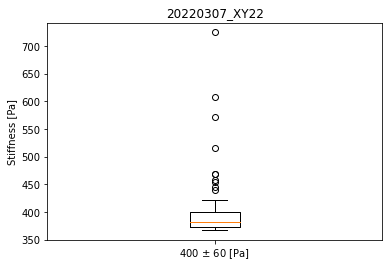

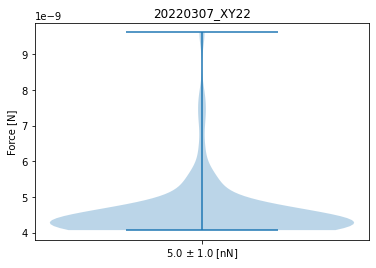

In [23]:
effective_E(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)
measured_Fn_plots(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)

### XY09

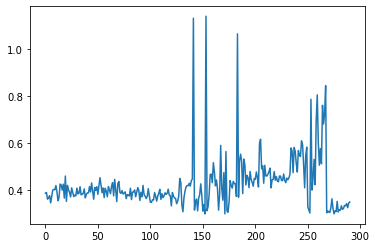

In [24]:
name = "20220307_XY09"
disps = np.load(data_path + name + ".npy")
Diameter_nucleus = 13e-6
displacements= disps*1e-6
bridgewidth_initial = 6.1e-6


gel_displacement(2800, 6.1*1e-6, 620, 13.4*1e-6, 0.5, 0.5)*1e6
plt.plot(disps)

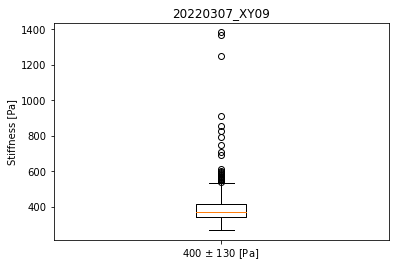

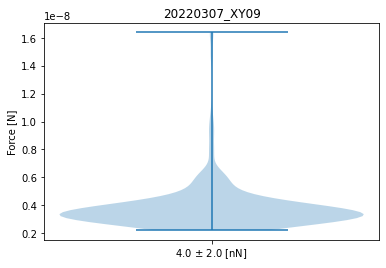

In [25]:
effective_E(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)
measured_Fn_plots(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)

### XY05

6.733333333333333
12.466666666666667


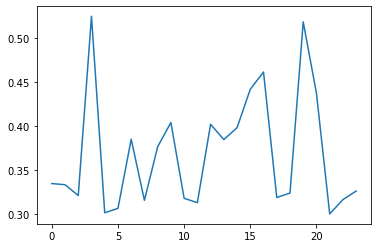

In [26]:
print((8.1+5.5+6.6)/3)
print((15.3+11.2+10.9)/3)
name = "20220307_XY05"
disps = np.load(data_path + name + ".npy")
Diameter_nucleus = 12.5e-6
displacements= disps*1e-6
bridgewidth_initial = 6.7e-6

plt.plot(disps)

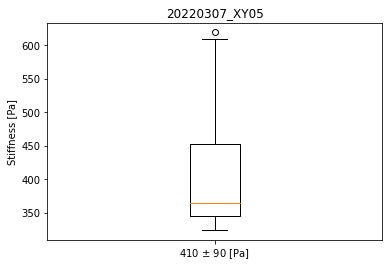

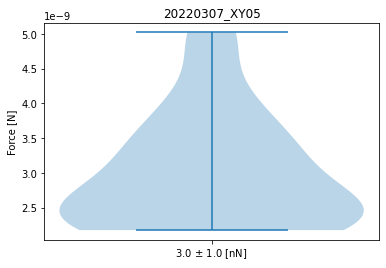

In [27]:
effective_E(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)
measured_Fn_plots(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)

## 20220211
### XY17

14.024999999999999
4.875 0.5068283733178321


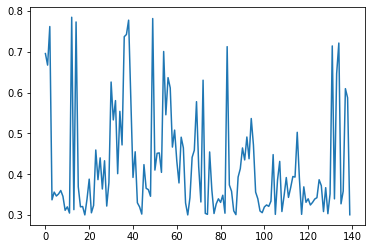

In [28]:
name = "20220211_XY17"
disps = np.load(data_path + name + ".npy")
print((14.3+13.7+9.4+18.7)/4)
print((4.2+4.7+5+5.6)/4, np.std([4.2,4.7,5,5.6]))
Diameter_nucleus = 14e-6
displacements= disps*1e-6
bridgewidth_initial = 4.9e-6


plt.plot(disps)

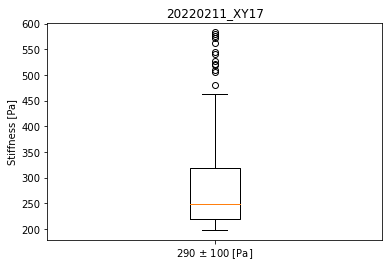

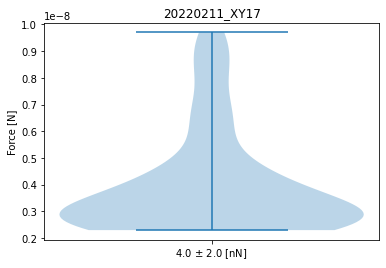

In [29]:
effective_E(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)
measured_Fn_plots(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)

### XY21

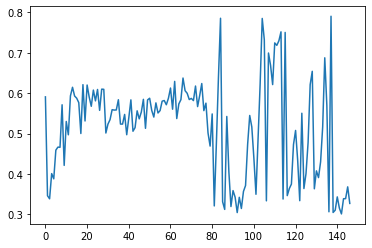

In [30]:
name = "20220211_XY21"
disps = np.load(data_path + name + ".npy")
Diameter_nucleus = 13.2e-6
displacements= disps*1e-6
bridgewidth_initial = 6.6e-6


plt.plot(disps)

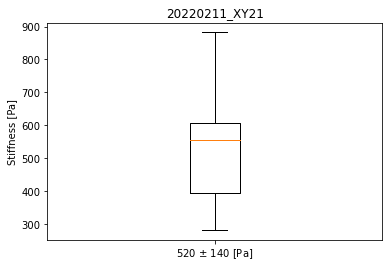

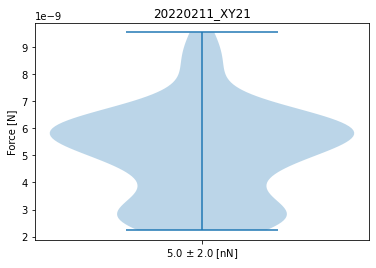

In [31]:
effective_E(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)
measured_Fn_plots(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)

## 20220520

### XY06

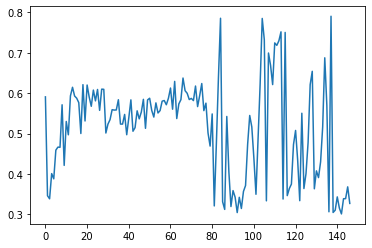

In [32]:
name = "20220520_XY06"
disps = np.load(data_path + name + ".npy")
Diameter_nucleus = 12.9e-6
displacements= disps*1e-6
bridgewidth_initial = 5.2e-6


plt.plot(disps)

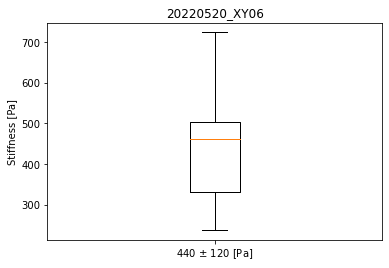

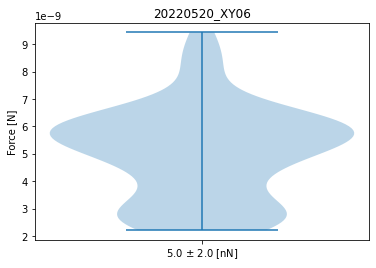

In [33]:
effective_E(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)
measured_Fn_plots(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)

### XY02

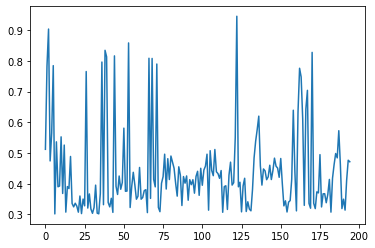

In [34]:
name = "20220520_XY02"
disps = np.load(data_path + name + ".npy")
Diameter_nucleus = 11.5e-6
displacements= disps*1e-6
bridgewidth_initial = 4.5e-6


plt.plot(disps)

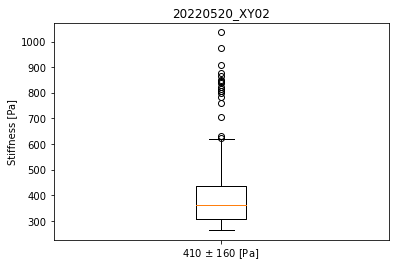

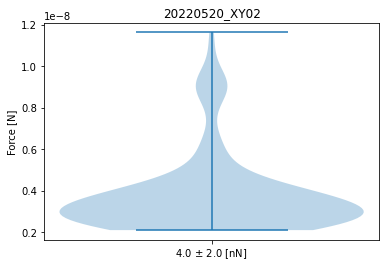

In [35]:
effective_E(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)
measured_Fn_plots(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)

## 20220603

### xy20 -1

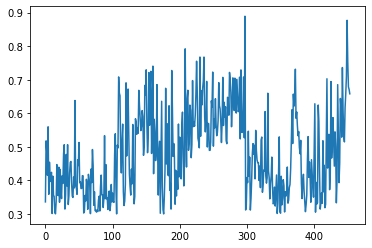

In [36]:
name = "20220603_XY20"
disps = np.load(data_path + name + ".npy")
Diameter_nucleus = np.mean([27e-6, 21.7e-6, 25.8e-6, 24.4e-6])
displacements= disps*1e-6
bridgewidth_initial = 4.1e-6


plt.plot(disps)

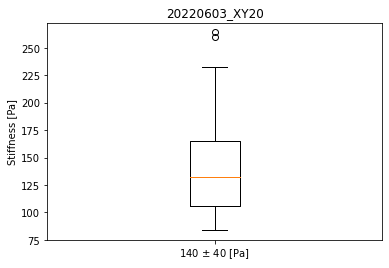

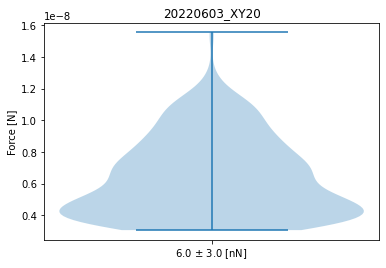

In [37]:
effective_E(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)
measured_Fn_plots(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)

### XY03 -1

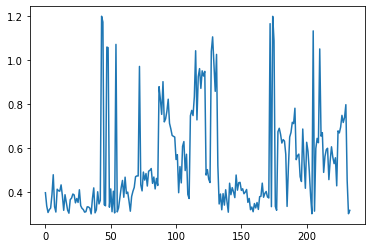

In [38]:
name = "20220603_XY03-1"
disps = np.load(data_path + name + ".npy")
Diameter_nucleus = np.mean([12.706, 16.557, 12.859, 10.246, 19.153])*1e-6
displacements= disps*1e-6
bridgewidth_initial = np.mean([5.1, 4.5, 3.1])*1e-6

plt.plot(disps)

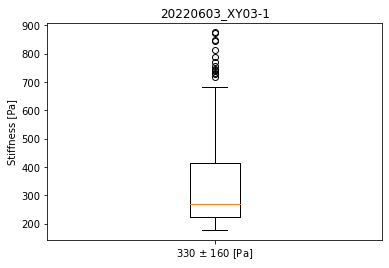

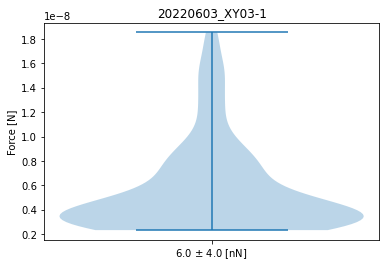

In [39]:
effective_E(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)
measured_Fn_plots(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)

### XY03 -2 - very little displacement may be outlier and deletable

1.4578166666666665e-05 3.8806666666666666e-06


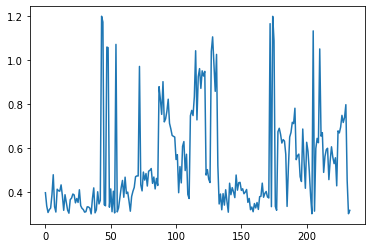

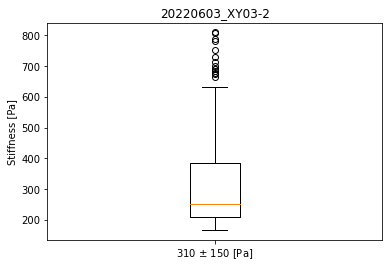

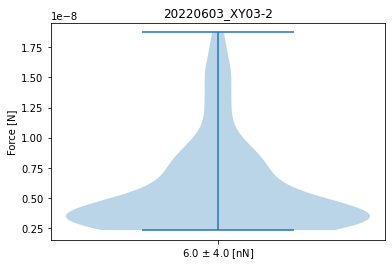

In [40]:
name = "20220603_XY03-2"
disps = np.load(data_path + name + ".npy")
Diameter_nucleus = np.mean([15.331,11.585,14.157,14.025,14.157,18.214])*1e-6
displacements= disps*1e-6
bridgewidth_initial = np.mean([5.445, 4.290, 2.805, 4.303, 4.125, 2.316])*1e-6
print(Diameter_nucleus, bridgewidth_initial)
plt.plot(disps)

effective_E(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)
measured_Fn_plots(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)

### XY07 -1

1.6199999999999997e-05 3.2e-06


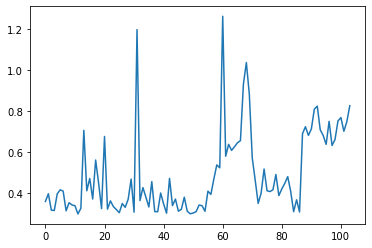

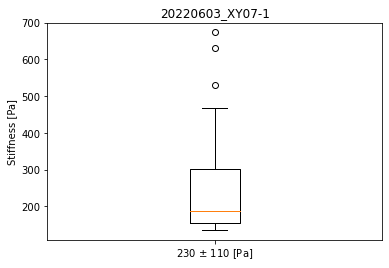

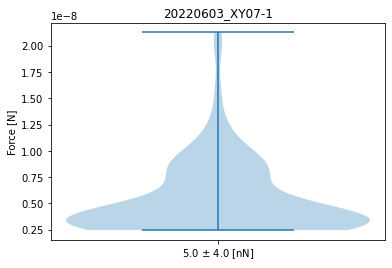

In [41]:
name = "20220603_XY07-1"
disps = np.load(data_path + name + ".npy")
Diameter_nucleus = np.mean([16.2])*1e-6
displacements= disps*1e-6
bridgewidth_initial = np.mean([3.2])*1e-6
print(Diameter_nucleus, bridgewidth_initial)
plt.plot(disps)

effective_E(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)
measured_Fn_plots(name, displacements, bridgewidth_initial, Diameter_nucleus, E_gel=2.8e3, nu_gel=0.5, nu_ball=0.5)

## All Together

In [42]:
big_res
flat_ls = [item for sublist in big_res for item in sublist]
res = np.array(flat_ls)

E_eff = int(np.round(np.mean(res),-2))
E_eff_std = int(np.round(res.std(),-2))

res_afm = np.load("AFM_nuclei.npy")
E_afm = int(np.round(np.mean(res_afm),-2))
E_afm_std = int(np.round(res_afm.std(),-2))


big_res_E_hydrogel
flat_ls_h = [item for sublist in big_res_E_hydrogel for item in sublist]
res_h = np.array(flat_ls_h)

E_eff_h = int(np.round(np.mean(res_h),-2))
E_eff_h_std = int(np.round(res_h.std(),-2))


res_h_afm = np.load("AFM_softgels.npy")
E_h_afm = int(np.round(np.mean(res_h_afm),-2))
E_h_afm_std = int(np.round(res_h_afm.std(),-2))

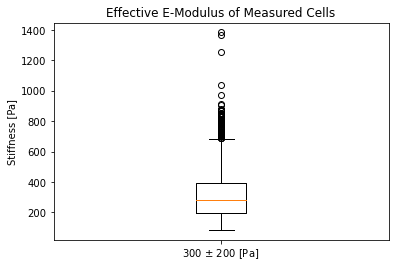

In [43]:
name="Effective E-Modulus of Measured Cells"
fig, ax = plt.subplots()
ax.boxplot([res], showfliers=True)
ax.set_ylabel("Stiffness [Pa]")
#ax.set_xlabel("All together, 1st, 2nd, & 3rd Transition [Pa]")
#ax.set_title(f'Stiffness of the Nucleus: left: all together, right: 1st, 2nd, & 3rd Transition')
ax.set_xticklabels([f"{E_eff} $\pm$ {E_eff_std} [Pa]"])
ax.set_title(name)
fig.savefig(str(name+"_EffectiveE.png"), dpi=300)
fig.savefig(str(name+"_EffectiveE.pdf"), dpi=300)
plt.show()

In [44]:
from matplotlib.markers import TICKDOWN

def significance_bar(start,end,height,displaystring,linewidth = 1.2,markersize = 8,boxpad  =0.3,fontsize = 15,color = 'k'):
    # draw a line with downticks at the ends
    plt.plot([start,end],[height]*2,'-',color = color,lw=linewidth,marker = TICKDOWN,markeredgewidth=linewidth,markersize = markersize)
    # draw the text with a bounding box covering up the line
    plt.text(0.5*(start+end),height,displaystring,ha = 'center',va='center',bbox=dict(facecolor='1.', edgecolor='none',boxstyle='Square,pad='+str(boxpad)),size = fontsize)

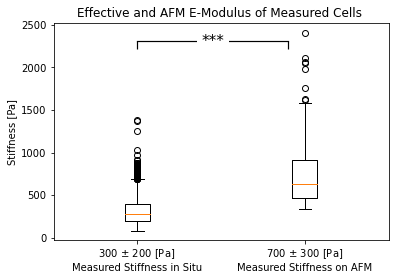

In [45]:
name="Effective and AFM E-Modulus of Measured Cells "


fig, ax = plt.subplots()
ax.boxplot([res, res_afm], showfliers=1)
ax.set_ylabel("Stiffness [Pa]")

#ax.set_xlabel("All together, 1st, 2nd, & 3rd Transition [Pa]")
#ax.set_title(f'Stiffness of the Nucleus: left: all together, right: 1st, 2nd, & 3rd Transition')
ax.set_xticklabels([f"{E_eff} $\pm$ {E_eff_std} [Pa] \nMeasured Stiffness in Situ", 
                   f"{E_afm} $\pm$ {E_afm_std} [Pa] \nMeasured Stiffness on AFM"])


pvals = [stats.mannwhitneyu(res, res_afm)[1]]
offset  =-100
for i,p in enumerate(pvals):
    if p>=0.05:
        displaystring = r'n.s.'
    elif p<0.0001:
        displaystring = r'***'
    elif p<0.001:
        displaystring = r'**'
    else:
        displaystring = r'*'
    
    bar_width=0.45
    height = offset +  max(res_afm) 
    bar_centers = [1,2][i] + np.array([0,2])*bar_width
    significance_bar(bar_centers[0],bar_centers[1],height,displaystring)


ax.set_title(name)
fig.savefig(str(name+"_EffectiveE.png"), dpi=300)
fig.savefig(str(name+"_EffectiveE.pdf"), dpi=300)
plt.show()

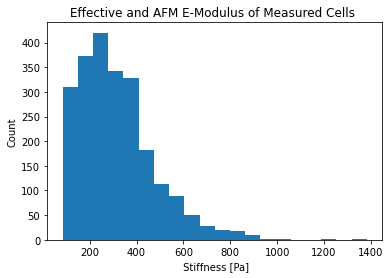

In [46]:
plt.hist(res, bins=20)
plt.ylabel("Count")
plt.xlabel(f" Stiffness [Pa]")
plt.title(name)
plt.savefig(str(name+"_EffectiveE_hist.png"), dpi=300)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7ffb4c7e82b0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7ffb4cf33640>,
 'cmins': <matplotlib.collections.LineCollection at 0x7ffb4c7d6910>,
 'cbars': <matplotlib.collections.LineCollection at 0x7ffb4c7d6970>}

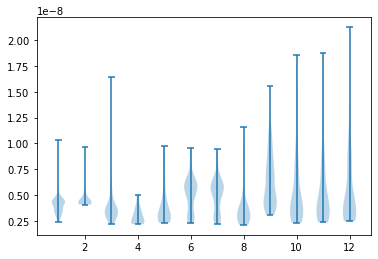

In [47]:
plt.violinplot( np.array(big_res_fn[:], dtype=object))

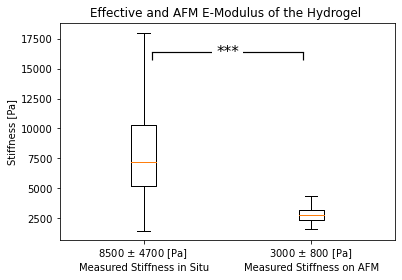

In [48]:
name="Effective and AFM E-Modulus of the Hydrogel "


fig, ax = plt.subplots()
ax.boxplot([res_h, res_h_afm], showfliers=0)
ax.set_ylabel("Stiffness [Pa]")

#ax.set_xlabel("All together, 1st, 2nd, & 3rd Transition [Pa]")
#ax.set_title(f'Stiffness of the Nucleus: left: all together, right: 1st, 2nd, & 3rd Transition')
ax.set_xticklabels([f"{E_eff_h} $\pm$ {E_eff_h_std} [Pa] \nMeasured Stiffness in Situ", 
                   f"{E_h_afm} $\pm$ {E_h_afm_std} [Pa] \nMeasured Stiffness on AFM"])


pvals = [stats.mannwhitneyu(res, res_afm)[1]]
offset  =-8000
for i,p in enumerate(pvals):
    if p>=0.05:
        displaystring = r'n.s.'
    elif p<0.0001:
        displaystring = r'***'
    elif p<0.001:
        displaystring = r'**'
    else:
        displaystring = r'*'
    
    bar_width=0.45
    height = offset +  max(res_h) 
    bar_centers = [1,2][i]+0.05 + np.array([0,2])*bar_width
    significance_bar(bar_centers[0],bar_centers[1],height,displaystring)


ax.set_title(name)
fig.savefig(str(name+"_EffectiveE.png"), dpi=300)
fig.savefig(str(name+"_EffectiveE.pdf"), dpi=300)
plt.show()

4.970152777777778e-06

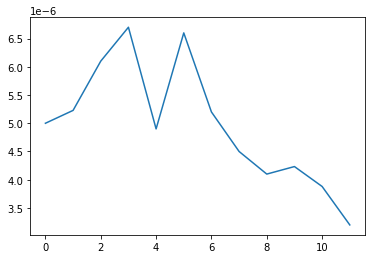

In [49]:
plt.plot(initial_widths)
np.mean(initial_widths)

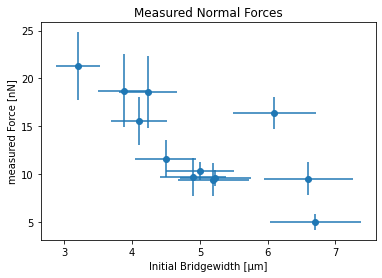

In [50]:
x = initial_widths
y = [np.array(big_res_fn[i]).max() for i in range(len(x)) ]
yerr = [np.array(big_res_fn[i]).std() for i in range(len(x)) ]
xerr = [x[i]*0.1 for i in range(len(x)) ]


name="Measured Normal Forces"

plt.errorbar(np.array(x)*1e6, np.array(y)*1e9, np.array(yerr)*1e9, np.array(xerr)*1e6, fmt="o")
plt.title(name)
plt.xlabel("Initial Bridgewidth [µm]")
plt.ylabel("measured Force [nN]")
plt.savefig(str(name+"_All.png"), dpi=300)
plt.show()

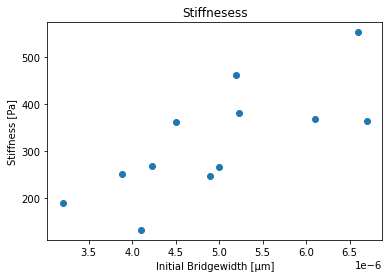

In [51]:
x = initial_widths
y = [np.median(np.array(big_res[i])) for i in range(len(x)) ]
#yerr = [np.array(big_res[i]).std() for i in range(len(x)) ]
#xerr = [x[i]*0.1 for i in range(len(x)) ]


name="Stiffnesess"

plt.plot(np.array(x), np.array(y), "o")
plt.title(name)
plt.xlabel("Initial Bridgewidth [µm]")
plt.ylabel("Stiffness [Pa]")
#plt.savefig(str(name+"_All.png"), dpi=300)
plt.show()

# Fn

In [52]:
confh = np.linspace(3,11)
initial_diameter = np.mean([14, 13, 13, 12.5, 14, 13.2, 12.9, 11.5])*1e-6
E_nucleus_afm = E_afm
E_nucleus_afm_std = E_afm_std
E_nucleus_eff = E_eff
E_nucleus_eff_std = E_eff_std

## with the AFM Value for E

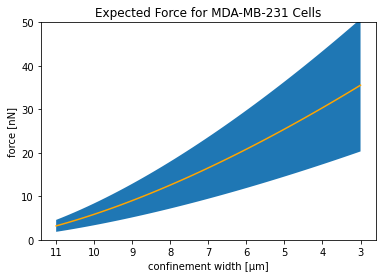

In [53]:
plt.plot(confh, Ball_F_nucleus_in_bridge(confh*1e-6, E_nucleus_afm, initial_diameter, 0.5)*1e9, label=f"E={E_nucleus_afm}Pa", c="orange")
small_E =  Ball_F_nucleus_in_bridge(confh*1e-6, E_nucleus_afm - E_nucleus_afm_std, initial_diameter, 0.5)*1e9
big_E =  Ball_F_nucleus_in_bridge(confh*1e-6, E_nucleus_afm + E_nucleus_afm_std, initial_diameter, 0.5)*1e9

plt.fill_between(confh, small_E, big_E)
plt.xlabel("confinement width [µm]")
plt.ylabel("force [nN]")
ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(0, 50)
plt.draw()
#plt.legend()
plt.title("Expected Force for MDA-MB-231 Cells")
plt.savefig("ForceOfMDAMB231s_Final_AFM_E.png", dpi=300)

## With Measured Effective E
you can change the xlim here to see difference next to AFM measruements

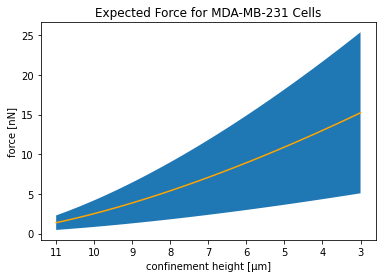

In [54]:
plt.plot(confh, Ball_F_nucleus_in_bridge(confh*1e-6, E_nucleus_eff, initial_diameter, 0.5)*1e9, label=f"E={E_nucleus_eff}Pa", c="orange")
small_E =  Ball_F_nucleus_in_bridge(confh*1e-6, E_nucleus_eff - E_nucleus_eff_std, initial_diameter, 0.5)*1e9
big_E =  Ball_F_nucleus_in_bridge(confh*1e-6, E_nucleus_eff + E_nucleus_eff_std, initial_diameter, 0.5)*1e9

plt.fill_between(confh, small_E, big_E)
plt.xlabel("confinement height [µm]")
plt.ylabel("force [nN]")
ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])

plt.draw()

plt.title("Expected Force for MDA-MB-231 Cells")
plt.savefig("ForceOfMDAMB231s_Final_Effective_E.png", dpi=300)

### with the measured data both extremes hard wall hard sphere

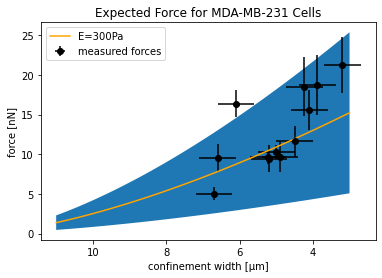

In [55]:
# theo forces with eff E with measured forcs
small_E =  Ball_F_nucleus_in_bridge(confh*1e-6, E_nucleus_eff - E_nucleus_eff_std, initial_diameter)*1e9
big_E =  Ball_F_nucleus_in_bridge(confh*1e-6, E_nucleus_eff + E_nucleus_eff_std, initial_diameter)*1e9

# measured forces
x = initial_widths
y = [np.array(big_res_fn[i]).max() for i in range(len(x)) ]
yerr = [np.array(big_res_fn[i]).std() for i in range(len(x)) ]
#xerr = [x[i]*0.1 for i in range(len(x)) ]
xerr = [0.5e-6 for i in range(len(x)) ]

plt.plot(confh, Ball_F_nucleus_in_bridge(confh*1e-6, E_nucleus_eff, initial_diameter, 0.5)*1e9, label=f"E={E_nucleus_eff}Pa", c="orange")
plt.fill_between(confh, small_E, big_E )
plt.errorbar(np.array(x)*1e6, np.array(y)*1e9, np.array(yerr)*1e9, np.array(xerr)*1e6, fmt="o", label="measured forces", color="black")

plt.xlabel("confinement width [µm]")
plt.ylabel("force [nN]")
plt.legend(loc="upper left")
ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])

plt.draw()

plt.title("Expected Force for MDA-MB-231 Cells")
plt.savefig("ForceOfMDAMB231s_Final_Effective_E_with_meas_forces.png", dpi=300)
plt.savefig("ForceOfMDAMB231s_Final_Effective_E_with_meas_forces.pdf", dpi=300)

### only measured forces

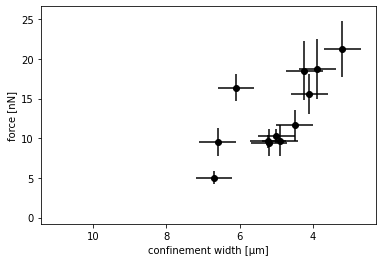

In [56]:
# theo forces with eff E with measured forcs
small_E =  Ball_F_nucleus_in_bridge(confh*1e-6, E_nucleus_eff - E_nucleus_eff_std, initial_diameter)*1e9
big_E =  Ball_F_nucleus_in_bridge(confh*1e-6, E_nucleus_eff + E_nucleus_eff_std, initial_diameter)*1e9

# measured forces
x = initial_widths
y = [np.array(big_res_fn[i]).max() for i in range(len(x)) ]
yerr = [np.array(big_res_fn[i]).std() for i in range(len(x)) ]
#xerr = [x[i]*0.1 for i in range(len(x)) ]
xerr = [0.5e-6 for i in range(len(x)) ]

#plt.plot(confh, Ball_F_nucleus_in_bridge(confh*1e-6, E_nucleus_eff, initial_diameter, 0.5)*1e9, label=f"E={E_nucleus_eff}Pa", c="orange")
plt.fill_between(confh, small_E, big_E, color="None" )
plt.errorbar(np.array(x)*1e6, np.array(y)*1e9, np.array(yerr)*1e9, np.array(xerr)*1e6, fmt="o", label="measured forces", color="black")

plt.xlabel("confinement width [µm]")
plt.ylabel("force [nN]")
#plt.legend(loc="upper left")
ax = plt.gca()
#ax.set_xlim(x[0]*1e6, x[-1]*1e6)
ax.set_xlim(ax.get_xlim()[::-1])

plt.draw()

#plt.title("Expected Force for MDA-MB-231 Cells")
plt.savefig("ForceOfMDAMB231s_only_meas_forces.png", dpi=300)
plt.savefig("ForceOfMDAMB231s_only_meas_forces.pdf", dpi=300)

# for non scientific audience

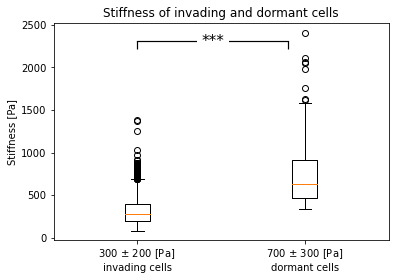

In [63]:
name="Stiffness of invading and dormant cells"


fig, ax = plt.subplots()
ax.boxplot([res, res_afm], showfliers=1)
ax.set_ylabel("Stiffness [Pa]")

#ax.set_xlabel("All together, 1st, 2nd, & 3rd Transition [Pa]")
#ax.set_title(f'Stiffness of the Nucleus: left: all together, right: 1st, 2nd, & 3rd Transition')
ax.set_xticklabels([f"{E_eff} $\pm$ {E_eff_std} [Pa] \ninvading cells", 
                   f"{E_afm} $\pm$ {E_afm_std} [Pa] \ndormant cells"])


pvals = [stats.mannwhitneyu(res, res_afm)[1]]
offset  =-100
for i,p in enumerate(pvals):
    if p>=0.05:
        displaystring = r'n.s.'
    elif p<0.0001:
        displaystring = r'***'
    elif p<0.001:
        displaystring = r'**'
    else:
        displaystring = r'*'
    
    bar_width=0.45
    height = offset +  max(res_afm) 
    bar_centers = [1,2][i] + np.array([0,2])*bar_width
    significance_bar(bar_centers[0],bar_centers[1],height,displaystring)


ax.set_title(name)
fig.savefig(str(name+"_EffectiveE.png"), dpi=300)
fig.savefig(str(name+"_EffectiveE.pdf"), dpi=300)
plt.show()